In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.env.Pendulum import InvertedPendulum
import pickle




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

gpu
[cuda(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [ ]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

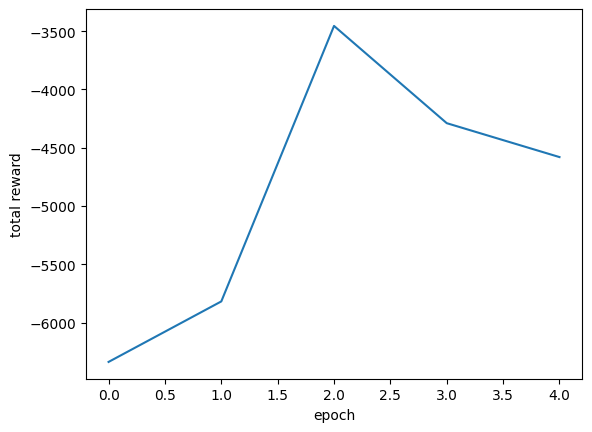

big epoch: 4 small epoch: 0 Loss 0.0001510094482340553
big epoch: 4 small epoch: 1 Loss 0.0003258239237776487
big epoch: 4 small epoch: 2 Loss 0.0003021209199327349
big epoch: 4 small epoch: 3 Loss 0.0002138612033948114
big epoch: 4 small epoch: 4 Loss 0.0001441168439706909
big epoch: 4 small epoch: 5 Loss 0.00013546446865444537
big epoch: 4 small epoch: 6 Loss 0.00013398291465470237
big epoch: 4 small epoch: 7 Loss 0.0001283949602894264
big epoch: 4 small epoch: 8 Loss 0.00012187929074341405
big epoch: 4 small epoch: 9 Loss 0.00012901689007992624
big epoch: 4 small epoch: 10 Loss 0.00013058408559269517
big epoch: 4 small epoch: 11 Loss 0.00013631677720640656
big epoch: 4 small epoch: 12 Loss 0.0001448953370072009
big epoch: 4 small epoch: 13 Loss 0.00015068986940862207
big epoch: 4 small epoch: 14 Loss 0.00016555368411732437
big epoch: 4 small epoch: 15 Loss 0.0001686306969178091
big epoch: 4 small epoch: 16 Loss 0.0001779273377985183
big epoch: 4 small epoch: 17 Loss 0.00018353805405

In [ ]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

#policy = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=4, inner_epochs=20, alpha_a=1e-5, init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f)
policy = train_pods(env,trajectory_length=100 ,num_samples=100,epochs=20, inner_epochs=20, alpha_a=5e-5, progress_fn=progress_f)

In [ ]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.09321289]
[0.07516986]
[-0.079196]
[-0.26876212]
[-0.3629303]
[-0.23650871]
[-0.02863274]
[0.0893449]
[0.09735289]
[0.09735289]
[0.09735289]
[0.09735289]
[0.08964089]
[0.07604055]
[-0.00576623]
[-0.11433812]
[-0.23534331]
[-0.37573934]
[-0.50532478]
[-0.5756865]
[-0.60929168]
[-0.6349647]
[-0.6587728]
[-0.66663736]
[-0.67192425]
[-0.67554862]
[-0.670632]
[-0.6602943]
[-0.64963701]
[-0.64636058]
[-0.65153056]
[-0.66588539]
[-0.68813481]
[-0.71137727]
[-0.73299355]
[-0.75134832]
[-0.76497329]
[-0.7721679]
[-0.77918121]
[-0.7867778]
[-0.79519001]
[-0.8038903]
[-0.81336856]
[-0.82355326]
[0.09735289]
[-0.08023162]
[-0.1025029]
[0.18401186]
[0.42154123]
[0.58140713]
[0.55426115]
[0.58300519]
[0.77582884]
[0.79205394]
[0.80749485]
[0.81430216]
[0.76931051]
[0.71303432]
[0.65818128]
[0.60764274]
[0.54103436]
[0.47068114]
[0.40858944]
[0.36439197]
[0.33310547]
[0.29765415]
[0.26242229]
[0.21912964]
[0.13936831]
[0.01194026]
[-0.06132478]
[-0.15211977]
[-0.24645402]
[-0.39387856]
[-0.5243838

In [ ]:

yes=html.render(env.sys.replace(dt=env.dt), rollout)
with open("data.html", "w") as file:
    file.write(yes)